In [1]:
from datasets import load_dataset
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

dataset = {}
for split in ["train", "validation", "test"]:
    dataset[split] = load_dataset("ILSVRC/imagenet-1k", trust_remote_code=True, split=split)


transforms_list = Compose(
    [
        Resize(size=(224, 224)),
        ToTensor(),
        Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)


def transforms(examples):
    examples["pixel_values"] = [transforms_list(image.convert("RGB")) for image in examples["image"]]
    return examples


dataset["train"].set_transform(transforms)
dataset["validation"].set_transform(transforms)
dataset["test"].set_transform(transforms)

from torch.utils.data import Dataset, DataLoader


class HFDataset(Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()

        self.dataset = dataset

    def __getitem__(self, index):
        data = self.dataset[index]
        return data["pixel_values"], data["label"]

    def __len__(self):
        return len(self.dataset)


train_dataset = HFDataset(dataset["train"])
validation_dataset = HFDataset(dataset["validation"])

/home/davor/miniconda3/envs/ramp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch import nn
from types import MethodType
from copy import deepcopy
from ramp_gae.utils import normalize_abs_sum_to_one, normalize_relevance, NormalizationType
import timm

# model = timm.create_model("vgg16", pretrained=True)
model = timm.create_model("resnet50", pretrained=True)
model.eval()


class LRPRule:
    def __init__(self):
        self.module_to_rule_dict = {}
        self.default_rule = None

    def rule_for_layer(self, module: nn.Module):
        raise NotImplemented("rule_for_layer must be implemented")


class AbsLRPRule(LRPRule):
    def __init__(self):
        self.module_to_rule_dict = {}
        self.default_rule = abslrp_rule

    def rule_for_layer(self, module: nn.Module):
        for module_class, rule in self.module_to_rule_dict.items():
            if isinstance(module, module_class):
                return rule
        return self.default_rule


def identity_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    return output_relevance


def abslrp_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    input = self.saved_tensors["input"][0]
    output = self.saved_tensors["output"]
    if "abs_output" in self.saved_tensors:
        output = output + self.saved_tensors["abs_output"]
    print(self.__class__.__name__, output_relevance.shape, output.shape)
    output_relevance = output_relevance / (self.saved_tensors["output"].abs() + 1e-9)
    # apply abslrp rule
    relevance = torch.autograd.grad(output, input, output_relevance)[0] * input
    relevance = normalize_relevance(relevance=relevance, normalization_type=NormalizationType.SUM_TO_ONE)
    # delete saved tensors
    self.saved_tensors = {}
    return relevance


def composite_abslrp_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    for child in list(self.children())[::-1]:
        output_relevance = child.explain(output_relevance)
    return output_relevance


def abslrp_forward_hook(module: nn.Module, args: tuple, output: torch.tensor) -> None:
    module.saved_tensors = {}
    # create a temporary temp module
    abs_module = deepcopy(module)
    # remove this hook from copied model
    if getattr(abs_module, "_forward_hooks", None):
        for i, hook in abs_module._forward_hooks.items():
            if hook.__name__ == "abslrp_forward_hook":
                break
        del abs_module._forward_hooks[i]
    # if module has learnable parameters, infer over absolute parameters
    if getattr(module, "weight", None) is not None:
        abs_module.weight.data = abs_module.weight.data.abs()
        if getattr(module, "bias", None) is not None:
            abs_module.bias.data = abs_module.bias.data.abs()
    abs_output = abs_module(*[arg.abs() for arg in args])
    # save the outputs and inputs
    module.saved_tensors["abs_output"] = abs_output
    module.saved_tensors["output"] = output
    module.saved_tensors["input"] = args


def apply_rule(module: nn.Module, rule: LRPRule) -> list[nn.Module]:
    children_list = list(module.children())
    if not children_list:
        explain_func = rule.rule_for_layer(module)
        module.explain = MethodType(explain_func, module)
        module.register_forward_hook(abslrp_forward_hook)
        return

    module.explain = MethodType(composite_abslrp_rule, module)
    for child_module in children_list:
        apply_rule(child_module, rule=rule)

    return


apply_rule(model, AbsLRPRule())

In [3]:
"""model = nn.Sequential(nn.Linear(2, 2, bias=False), nn.Linear(2, 2, bias=False))

model[0].weight.data = torch.tensor([[2.0, -1], [-5, 6]])
model[1].weight.data = torch.tensor([[1.0, 0], [0, 1]])

x = torch.tensor([[1.0, 1]])
x.requires_grad = True

apply_rule(model, AbsLRPRule())

model(x), model.explain(torch.tensor([[1.0, -1]]))"""

'model = nn.Sequential(nn.Linear(2, 2, bias=False), nn.Linear(2, 2, bias=False))\n\nmodel[0].weight.data = torch.tensor([[2.0, -1], [-5, 6]])\nmodel[1].weight.data = torch.tensor([[1.0, 0], [0, 1]])\n\nx = torch.tensor([[1.0, 1]])\nx.requires_grad = True\n\napply_rule(model, AbsLRPRule())\n\nmodel(x), model.explain(torch.tensor([[1.0, -1]]))'

In [4]:
import torch.nn.functional as F
from torch.utils.data import DataLoader

validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)
for x, y in validation_loader:
    break

# x = torch.randn(2, 3, 224, 224)

x.requires_grad = True
output = model(x)
# output_relevance = output.detach()
output_relevance = F.one_hot(output.max(-1)[1], num_classes=output.shape[-1])
# output_relevance = output_relevance - ((1 - output_relevance) / 1000)
# output_relevance = output_relevance - torch.ones_like(output_relevance) / 1000
print(output_relevance[0].sum())
relevance = model.explain(output_relevance=output_relevance)
print(relevance[0].sum())

tensor(1)
Linear torch.Size([4, 1000]) torch.Size([4, 1000])
Flatten torch.Size([4, 2048]) torch.Size([4, 2048])
AdaptiveAvgPool2d torch.Size([4, 2048, 1, 1]) torch.Size([4, 2048, 1, 1])
ReLU torch.Size([4, 2048, 7, 7]) torch.Size([4, 2048, 7, 7])
BatchNorm2d torch.Size([4, 2048, 7, 7]) torch.Size([4, 2048, 7, 7])
Conv2d torch.Size([4, 2048, 7, 7]) torch.Size([4, 2048, 7, 7])
Identity torch.Size([4, 512, 7, 7]) torch.Size([4, 512, 7, 7])
ReLU torch.Size([4, 512, 7, 7]) torch.Size([4, 512, 7, 7])
Identity torch.Size([4, 512, 7, 7]) torch.Size([4, 512, 7, 7])
BatchNorm2d torch.Size([4, 512, 7, 7]) torch.Size([4, 512, 7, 7])
Conv2d torch.Size([4, 512, 7, 7]) torch.Size([4, 512, 7, 7])
ReLU torch.Size([4, 512, 7, 7]) torch.Size([4, 512, 7, 7])
BatchNorm2d torch.Size([4, 512, 7, 7]) torch.Size([4, 512, 7, 7])
Conv2d torch.Size([4, 512, 7, 7]) torch.Size([4, 512, 7, 7])
ReLU torch.Size([4, 2048, 7, 7]) torch.Size([4, 2048, 7, 7])
BatchNorm2d torch.Size([4, 2048, 7, 7]) torch.Size([4, 2048, 7

RuntimeError: The size of tensor a (14) must match the size of tensor b (7) at non-singleton dimension 3

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

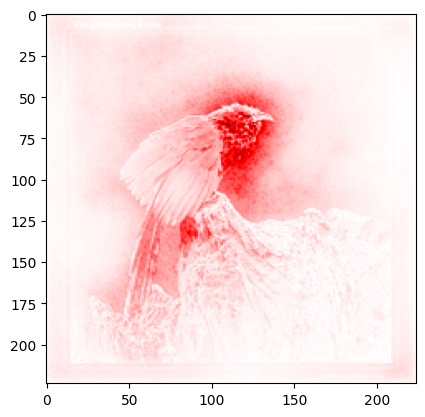

In [222]:
import matplotlib.pyplot as plt
%matplotlib inline
from ramp_gae.utils import normalize_relevance, NormalizationType

vis_example = 0
plt.imshow(normalize_relevance(relevance.sum(1), normalization_type=NormalizationType.MAX_TO_ONE)[vis_example].detach().cpu(), vmin=-1, vmax=1, cmap="seismic")
plt.show()

In [ ]:
x.requires_grad = True
output = model(x)
output_relevance = F.one_hot(output.max(-1)[1], num_classes=output.shape[-1])
positive_relevance = model.explain(output_relevance=output_relevance)

output = model(x)
output_relevance = 1 - F.one_hot(output.max(-1)[1], num_classes=output.shape[-1])
negative_relevance = model.explain(output_relevance=output_relevance)

relevance = normalize_abs_sum_to_one(positive_relevance) - normalize_abs_sum_to_one(negative_relevance)

output tensor(1)
<class 'torch.nn.modules.linear.Linear'> tensor(1.) tensor(1) tensor(0) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.dropout.Dropout'> tensor(1.) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.flatten.Flatten'> tensor(1.) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'> tensor(1.) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.conv.Conv2d'> tensor(1.0000) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.0000)
<class 'torch.nn.modules.dropout.Dropout'> tensor(1.0000) tensor(1.0000) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.0000)
<class 'torch.nn.modules.conv.Conv2d'> tensor(1.0000) t

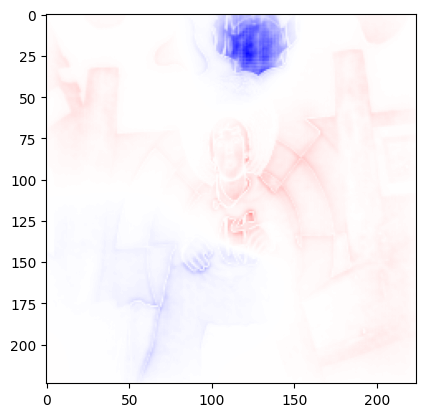

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from ramp_gae.utils import normalize_relevance, NormalizationType

vis_example = 7
plt.imshow(normalize_relevance(relevance.sum(1), normalization_type=NormalizationType.MAX_TO_ONE)[vis_example].detach().cpu(), vmin=-1, vmax=1, cmap="bwr")
plt.show()

# Test model

In [ ]:
model = nn.Sequential(nn.Linear(2, 2, bias=False), nn.Linear(2, 1, bias=False))

model[0].weight.data = torch.tensor([[2.0, -1], [-5, 6]])
model[1].weight.data = torch.tensor([[1.0, 1]])

x = torch.tensor([[1.0, 1]])
x.requires_grad = True

apply_rule(model, AbsLRPRule())

model(x), model.explain(torch.tensor([[1.0]]))

layer = nn.Linear(2, 2, bias=False)
layer.weight.data = torch.tensor([[2.0, -1], [-5, 6]])
abs_layer = deepcopy(layer)
abs_layer.weight.data = abs_layer.weight.data.abs()

h = layer(x)
ha = abs_layer(x)

torch.autograd.grad(h + ha, x, torch.tensor([[0.5, 0.5]]) / h.abs())[0] * x